In [ ]:
!pip install transformers
!pip install datasets
!pip install rouge.score nltk py7zr
!pip install rouge-score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.1 MB/s 
     |████████████████████████████████| 182 kB 66.8 MB/s 
     |████████████████████████████████| 7.6 MB 60.8 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 13.2 MB/s 
     |████████████████████████████████| 132 kB 39.7 MB/s 
     |████████████████████████████████| 212 kB 60.4 MB/s 
     |████████████████████████████████| 127 kB 59.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 65 kB 3.5 MB/s 
     |████████████████████████████████| 50 kB 4.3 MB/s 
     |████████████████████

In [ ]:
#reference: https://medium.com/@ferlatti.aldo/fine-tuning-a-chat-summarizer-c18625bc817d
import transformers
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from sklearn.model_selection import train_test_split
from datasets import load_dataset, load_metric, load_from_disk, Dataset, DatasetDict
import numpy as np
import nltk
import pandas as pd
nltk.download('punkt')
import matplotlib.pyplot as plt

import torch

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
#finetune a bart model 
max_input = 500
max_target = 300
batch_size = 5
model_checkpoints = "facebook/bart-large-xsum"
#model_checkpoints = "sshleifer/distilbart-xsum-12-3"
#model_checkpoints = "google/pegasus-xsum"
#model_checkpoints = "facebook/bart-large-cnn"


metric = load_metric('rouge')



<ipython-input-3-fb08386b227c>:11: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('rouge')


In [ ]:
# this cell splits the data into train, test, evaluation, Don't run this if you have already uploaded Train_intent.csv, Evaluation.csv and Test.csv
'''
data = pd.read_csv('final_training_data.csv',index_col=[0])
train_data, test_data = train_test_split(data, test_size = 0.10, random_state = None)
#train_data = train_data.reset_index()
#test_data = test_data.reset_index()
print(test_data)
test_data.to_csv("Test_intent.csv")
train_data.to_csv("Train_intent.csv")

# train, evaluation split
train_dataset, eval_dataset = train_test_split(train_data, test_size = 0.20, random_state = 0)
train_dataset.to_csv("Train_intent.csv")
eval_dataset.to_csv("Evaluation_intent.csv")
'''

'\ndata = pd.read_csv(\'final_training_data.csv\',index_col=[0])\ntrain_data, test_data = train_test_split(data, test_size = 0.10, random_state = None)\n#train_data = train_data.reset_index()\n#test_data = test_data.reset_index()\nprint(test_data)\ntest_data.to_csv("Test_intent.csv")\ntrain_data.to_csv("Train_intent.csv")\n\n# train, evaluation split\ntrain_dataset, eval_dataset = train_test_split(train_data, test_size = 0.20, random_state = 0)\ntrain_dataset.to_csv("Train_intent.csv")\neval_dataset.to_csv("Evaluation_intent.csv")\n'

In [ ]:

df_train = pd.read_csv('Train_intent.csv')
df_eval = pd.read_csv('Evaluation_intent.csv')
 
 
train = Dataset.from_pandas(df_train)
eval = Dataset.from_pandas(df_eval)
 
 
dataset = DatasetDict()
 
dataset['train'] = train
dataset['test'] = eval
 
dataset


DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'responses', 'summary'],
        num_rows: 32
    })
    test: Dataset({
        features: ['Unnamed: 0', 'responses', 'summary'],
        num_rows: 8
    })
})

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoints)


Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [ ]:
def preprocess_data(data_to_process):
  #get all the dialogues
  inputs = [response for response in data_to_process['responses']]
  #tokenize the dialogues
  #model_inputs = tokenizer(inputs,  max_length=max_input, padding='max_length', truncation=True)
  model_inputs = tokenizer(inputs,  padding='longest')
  #tokenize the summaries
  with tokenizer.as_target_tokenizer():
    targets = tokenizer(data_to_process['summary'], padding='longest')
    
  #set labels
  model_inputs['labels'] = targets['input_ids']
  #return the tokenized data
  #input_ids, attention_mask and labels
  return model_inputs

tokenized_dataset = dataset.map(preprocess_data, batched = True)
print(tokenized_dataset)

print(len(tokenized_dataset['train']['labels'][0]))
print(len(tokenized_dataset['train']['labels'][0]))



  0%|          | 0/1 [00:00<?, ?ba/s]

/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:3578: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'responses', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 32
    })
    test: Dataset({
        features: ['Unnamed: 0', 'responses', 'summary', 'input_ids', 'attention_mask', 'labels'],
        num_rows: 8
    })
})
93
93


In [ ]:
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoints)
collator = transformers.DataCollatorForSeq2Seq(tokenizer, model=model)

Downloading:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

In [ ]:
def compute_rouge(pred):
  predictions, labels = pred
  #decode the predictions
  decode_predictions = tokenizer.batch_decode(predictions, skip_special_tokens=True)
  #decode labels
  decode_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

  #compute results
  res = metric.compute(predictions=decode_predictions, references=decode_labels, use_stemmer=True)
  #get %
  res = {key: value.mid.fmeasure * 100 for key, value in res.items()}

  pred_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
  res['gen_len'] = np.mean(pred_lens)

  return {k: round(v, 4) for k, v in res.items()}


In [ ]:
args = Seq2SeqTrainingArguments(
    'summarizer', #save directory
    evaluation_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=5,
    per_device_eval_batch_size= 5,
    gradient_accumulation_steps=2,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=10,
    predict_with_generate=True,
    eval_accumulation_steps=3,
    fp16=True, #available only with CUDA
    logging_steps = 3
    )

trainer = Seq2SeqTrainer(
    model, 
    args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)

trainer.train()

Using cuda_amp half precision backend
The following columns in the training set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: Unnamed: 0, summary, responses. If Unnamed: 0, summary, responses are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 32
  Num Epochs = 10
  Instantaneous batch size per device = 5
  Total train batch size (w. parallel, distributed & accumulation) = 10
  Gradient Accumulation steps = 2
  Total optimization steps = 30
  Number of trainable parameters = 406290432
You're using a BartTokenizerFast tokenizer. Please note 

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Gen Len
0,7.026500,6.917099,29.827500,10.255000,23.690000,23.579500,19.375000
1,7.070200,5.523545,42.427900,17.082700,31.656300,31.394300,31.750000
2,5.419200,4.310239,50.098900,21.481700,33.231200,33.077400,55.875000
3,4.328700,3.078434,51.776500,23.411400,34.286200,34.155900,54.750000
4,2.975900,2.398523,52.269200,25.088200,40.267000,40.391200,35.000000
5,2.275800,2.057729,48.277300,22.282200,40.462900,40.510900,38.375000
6,1.879100,1.883879,53.002600,26.815000,40.055600,39.730500,41.250000
7,1.641800,1.785179,53.582200,25.531300,37.672100,37.236600,48.375000
8,1.479800,1.722447,52.870900,25.797600,39.202700,39.247800,49.250000
9,1.353500,1.689522,52.320000,26.240500,40.801800,40.520900,45.125000


The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: Unnamed: 0, summary, responses. If Unnamed: 0, summary, responses are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 5
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: Unnamed: 0, summary, responses. If Unnamed: 0, summary, responses are not expected by `BartForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 8
  Batch size = 5
The following columns in the evaluation set don't have a corresponding argument in `BartForConditionalGeneration.forward` and have been ignored: Unnamed: 0, summary, responses. If Unnamed: 0, summary, responses are not expected by `BartForConditional

TrainOutput(global_step=30, training_loss=3.5450420061747234, metrics={'train_runtime': 50.6584, 'train_samples_per_second': 6.317, 'train_steps_per_second': 0.592, 'total_flos': 152095189008384.0, 'train_loss': 3.5450420061747234, 'epoch': 9.86})

In [ ]:
#print(trainer.state.log_history[16]['loss'])# train loss index:1,3,5,7,7,10,12,14,16
#print(trainer.state.log_history[17]['eval_loss'])# eval train loss index:2,4,6,8,9,11,13,15,17
train_loss_list = []
eval_loss_list =[]
epoch_list = [1,2,3,4,5,6,7,8,9,10]
# get training loss
for data in trainer.state.log_history:
  if 'loss' in data.keys():
    train_loss_list.append(data['loss'])
  elif 'eval_loss' in data.keys():
    eval_loss_list.append(data['eval_loss'])
  else:
    pass

print(train_loss_list, len(train_loss_list))
print(eval_loss_list, len(eval_loss_list))
print(trainer.state.log_history)


[7.0265, 7.0702, 5.4192, 4.3287, 2.9759, 2.2758, 1.8791, 1.6418, 1.4798, 1.3535] 10
[6.9170989990234375, 5.523545265197754, 4.310239315032959, 3.0784339904785156, 2.3985233306884766, 2.0577285289764404, 1.8838791847229004, 1.7851791381835938, 1.722447156906128, 1.6895222663879395] 10
[{'loss': 7.0265, 'learning_rate': 1.9333333333333333e-05, 'epoch': 0.86, 'step': 3}, {'eval_loss': 6.9170989990234375, 'eval_rouge1': 29.8275, 'eval_rouge2': 10.255, 'eval_rougeL': 23.69, 'eval_rougeLsum': 23.5795, 'eval_gen_len': 19.375, 'eval_runtime': 1.8315, 'eval_samples_per_second': 4.368, 'eval_steps_per_second': 1.092, 'epoch': 0.86, 'step': 3}, {'loss': 7.0702, 'learning_rate': 1.7333333333333336e-05, 'epoch': 1.86, 'step': 6}, {'eval_loss': 5.523545265197754, 'eval_rouge1': 42.4279, 'eval_rouge2': 17.0827, 'eval_rougeL': 31.6563, 'eval_rougeLsum': 31.3943, 'eval_gen_len': 31.75, 'eval_runtime': 2.6694, 'eval_samples_per_second': 2.997, 'eval_steps_per_second': 0.749, 'epoch': 1.86, 'step': 6}, {

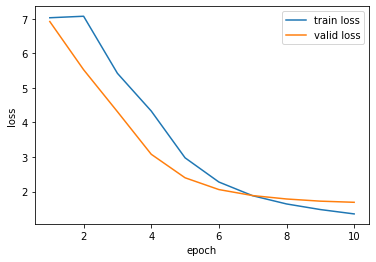

<Figure size 144x144 with 0 Axes>

In [ ]:

plt.plot(epoch_list,train_loss_list,label = "train loss")
plt.plot(epoch_list,eval_loss_list,label = "valid loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.figure(figsize=(2, 2))
plt.show()


In [ ]:
#save the model and load it
'''
model.save_pretrained("Saved_Model_bart-large-xsum", from_pt=True) 
loaded_model = AutoModelForSeq2SeqLM.from_pretrained("Saved_Model_bart-large-xsum")
'''
'''
model.save_pretrained("Saved_Model_distilbart-xsum-12-3", from_pt=True) 
loaded_model = AutoModelForSeq2SeqLM.from_pretrained("Saved_Model_distilbart-xsum-12-3")
'''
model.save_pretrained("Saved_Model_bart-large-cnn", from_pt=True) 
loaded_model = AutoModelForSeq2SeqLM.from_pretrained("Saved_Model_bart-large-cnn")

loaded_trainer = Seq2SeqTrainer(
    loaded_model, 
    args,
    train_dataset=tokenized_dataset['train'],
    eval_dataset=tokenized_dataset['test'],
    data_collator=collator,
    tokenizer=tokenizer,
    compute_metrics=compute_rouge
)



Configuration saved in Saved_Model_bart-large-cnn/config.json
Model weights saved in Saved_Model_bart-large-cnn/pytorch_model.bin
loading configuration file Saved_Model_bart-large-cnn/config.json
Model config BartConfig {
  "_name_or_path": "Saved_Model_bart-large-cnn",
  "_num_labels": 3,
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_bias_logits": false,
  "add_final_layer_norm": false,
  "architectures": [
    "BartForConditionalGeneration"
  ],
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classif_dropout": 0.0,
  "classifier_dropout": 0.0,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder_layerdrop": 0.0,
  "decoder_layers": 12,
  "decoder_start_token_id": 2,
  "dropout": 0.1,
  "early_stopping": true,
  "encoder_attention_heads": 16,
  "encoder_ffn_dim": 4096,
  "encoder_layerdrop": 0.0,
  "encoder_layers": 12,
  "eos_token_id": 2,
  "eos_token_ids": [
    2
  ],
  "forced_eos_token_id": 2,
  "gradient_checkpoint

In [ ]:
# testing the loaded model with a uploaded csv file

response = """
Teaching new staff (providing support). Be more considerate of client having PTSD some kind of trauma. Go back to appropriate self-care activities geared to me. Invovled more in code white situation. Trauma-informed care and de-escalation.Training gives me good understanding when to apply restraint Level 1 physical restraint when transferring patient and hand control.
"""
model_inputs = tokenizer(response)
#model_inputs = tokenizer(response),  	tokenizer(batch_sentences, padding='max_length', max_length=42)
raw_pred, _, _ = loaded_trainer.predict([model_inputs])
print(tokenizer.decode(raw_pred[0],skip_special_tokens = True))




***** Running Prediction *****
  Num examples = 1
  Batch size = 5


Teaching new staff support. Be more considerate of client having trauma. Invovled more in code white situation. Go back to appropriate self-care activities. Train more in trauma-informed care and de-escalation.


In [ ]:
#check the number of parameters
sum(p.numel() for p in model.parameters())



406290432

**Original text:**


In the applications on mechanical restraints and in management of aggressive behaviors  Apply same type of restraint to wrists/hands as to foot. Adjust tightness so not a chooking hazard  Properly putting restraints on i.e. feet together closer  1. Applying restraints and removing in way instructed today. 2. Trying to manage the client to try and prevent the use of mechanical restraints.  shoulder strap on head rest of bed Retraining events at work; setting up restraint work to improve flow at work  Wrist control while applying mechanical restraints  How to apply shoulder limb properly Practice applying restraints to stretcher, be more active in applying restraints in a restraint event  Hand position when applying restraints

**Summary:**


In the applications on mechanical restraints and in management of aggressive behaviors. Apply same type of restraint to wrists or hands as to foot. Adjust tightness so not to chooking hazard. Be more active in applying restraints in restraint event. Try to prevent the use of mechanical restraints.

In [ ]:
# applying model with test dataset

input_file = pd.read_csv("Test_intent.csv")
#print(input_file['responses'])
intent_output = []
for response in input_file['responses']:
  model_inputs = tokenizer(response)
  #model_inputs = tokenizer(response),  	tokenizer(batch_sentences, padding='max_length', max_length=42)
  raw_pred, _, _ = loaded_trainer.predict([model_inputs])
  intent_output.append(tokenizer.decode(raw_pred[0],skip_special_tokens = True))

***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


In [ ]:
print(intent_output)

['Work with other staff to ensure we work safely as a team. Be mindful of effect of our actions has on clients. Use technique to work with team. Encourage team on self-care. Support team on restraints. De-escalate trauma-informed care. More use of the Red Zone', 'Doing code white and de-escalation. Remembering trauma-informed practice while restraint. Use different trauma informed strategies than using restraints. Being in restraints allowed me to feel what it may be like for patients.', 'I intend to use the physical restraint strategies learned should the occasion arise. I feel confident applying mechanical restraint. We have a client that needs to be restraint during ECT.', 'Teaching new staff. Debriefing after restraint. Self-care. Apply restraints when client needs to be controlled. Protecting other staff from possible harm.', 'Be more considerate of client having PTSD. Always operate from a trauma-informed practice. De-esclate using verbal skills. Use restraints as a last resort. 

In [ ]:
print(len(input_file['responses']))
print(len(intent_output))

5
5


In [ ]:
print(input_file['responses'][0])
print(intent_output[0])

Work with other staff who already been training as team work To ensure we work safely as a team and be mindful of effect of our actions has on clients Safely manage agitated patient. Use technique to work with team Team work I plean to meet with my team and discuss strategies learnt. Encourage/support team on self-care. Support team on restraints because I fine tune my skills. De-escalating  Trauma-informed care , team communication, use of restraints  Will use PINEL discontinuation strategies more effectively Clock manuveurs and more use of the Red Zone (awareness). Invovled more in code white situation.
Work with other staff to ensure we work safely as a team. Be mindful of effect of our actions has on clients. Use technique to work with team. Encourage team on self-care. Support team on restraints. De-escalate trauma-informed care. More use of the Red Zone


In [ ]:
print(intent_output)

['Work with other staff to ensure we work safely as a team. Be mindful of effect of our actions has on clients. Use technique to work with team. Encourage team on self-care. Support team on restraints. De-escalate trauma-informed care. More use of the Red Zone', 'Doing code white and de-escalation. Remembering trauma-informed practice while restraint. Use different trauma informed strategies than using restraints. Being in restraints allowed me to feel what it may be like for patients.', 'I intend to use the physical restraint strategies learned should the occasion arise. I feel confident applying mechanical restraint. We have a client that needs to be restraint during ECT.', 'Teaching new staff. Debriefing after restraint. Self-care. Apply restraints when client needs to be controlled. Protecting other staff from possible harm.', 'Be more considerate of client having PTSD. Always operate from a trauma-informed practice. De-esclate using verbal skills. Use restraints as a last resort. 

In [ ]:
from rouge_score import rouge_scorer
scores = []
ref = ['Work as a team. Work safely and mind the effects of our actions to clients. Safely manage aggressive clients. Better team communication. Support on self-care. Use pinel discontinuation strategies more effectively. More red zone awareness.',
       'Trauma can make restrains events worst for patients and remember trauma-informed practice. Using trauma-informed strategies than using restraints and being in restraints allow staff feel the patients’ feel. Trauma-informed de-escalation prior to the use of restraints.',
       'When needed, people have more confidence in applying physical restraint strategy after this training. People also refreshed their knowledge of shoulder and limb restraint and have a better understanding of different levels of physical restraint.',
       'Protect agitated clients and staff from harm. Apply constraints to aggressive clients.Teaching new staff (providing support) about every code situation',
       'Be considerate of patient who has trauma. Using trauma-informed skills before using the seclusion room. Provide debrief assessment even if being refused to. Do trauma-informed care. Work harder to debrief client after trauma. Incorporate trauma awareness to decision on restraints. Assess rick of harm when dealing with client.']
sum = []

input_file = pd.read_csv("Test_intent.csv")
for response in input_file['responses']:
  model_inputs = tokenizer(response)
  #model_inputs = tokenizer(response),  	tokenizer(batch_sentences, padding='max_length', max_length=42)
  raw_pred, _, _ = loaded_trainer.predict([model_inputs])
  sum.append(tokenizer.decode(raw_pred[0],skip_special_tokens = True))

scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2','rougeL'], use_stemmer=True)

for i in range (len(ref)):
   scores.append (scorer.score(ref[i],sum[i]))

print(len(scores))


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


5


In [ ]:
print(scores[0])

rouge1 = 0
rouge2 = 0
rougeL = 0
for s in scores:
    rouge1 += s['rouge1'][2]
    rouge2 += s['rouge2'][2]
    rougeL += s['rougeL'][2]
    print(rouge1, rouge2,rougeL)

rouge1_avg = rouge1 / len(scores)
rouge2_avg = rouge2 / len(scores)
rougeL_avg = rougeL / len(scores)
print(rouge1_avg, rouge2_avg, rougeL_avg)

{'rouge1': Score(precision=0.4791666666666667, recall=0.6388888888888888, fmeasure=0.5476190476190476), 'rouge2': Score(precision=0.19148936170212766, recall=0.2571428571428571, fmeasure=0.21951219512195122), 'rougeL': Score(precision=0.3541666666666667, recall=0.4722222222222222, fmeasure=0.4047619047619048)}
0.5476190476190476 0.21951219512195122 0.4047619047619048
1.1692406692406692 0.5806233062330622 0.8912483912483913
1.4769329769329769 0.6758614014711575 1.1066330066330066
1.9420492560027443 0.8222028648857916 1.2926795182609134
2.282474787917638 0.8874202561901394 1.5479986671970836
0.4564949575835276 0.17748405123802788 0.3095997334394167


In [ ]:
!pip install evaluate
!pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 72 kB 1.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 60 kB 8.7 MB/s 


In [ ]:

from evaluate import load
bertscore = load("bertscore")


ref = ['Work as a team. Work safely and mind the effects of our actions to clients. Safely manage aggressive clients. Better team communication. Support on self-care. Use pinel discontinuation strategies more effectively. More red zone awareness.',
       'Trauma can make restrains events worst for patients and remember trauma-informed practice. Using trauma-informed strategies than using restraints and being in restraints allow staff feel the patients’ feel. Trauma-informed de-escalation prior to the use of restraints.',
       'When needed, people have more confidence in applying physical restraint strategy after this training. People also refreshed their knowledge of shoulder and limb restraint and have a better understanding of different levels of physical restraint.',
       'Protect agitated clients and staff from harm. Apply constraints to aggressive clients.Teaching new staff (providing support) about every code situation',
       'Be considerate of patient who has trauma. Using trauma-informed skills before using the seclusion room. Provide debrief assessment even if being refused to. Do trauma-informed care. Work harder to debrief client after trauma. Incorporate trauma awareness to decision on restraints. Assess rick of harm when dealing with client.']
sum = []

input_file = pd.read_csv("Test_intent.csv")
for response in input_file['responses']:
  model_inputs = tokenizer(response)
  #model_inputs = tokenizer(response),  	tokenizer(batch_sentences, padding='max_length', max_length=42)
  raw_pred, _, _ = loaded_trainer.predict([model_inputs])
  sum.append(tokenizer.decode(raw_pred[0],skip_special_tokens = True))


results = bertscore.compute(predictions=sum, references=ref, lang="en")
print(results)
precision = results["precision"]
#print(precision)
recall = results['recall']
f1 = results['f1']



***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


***** Running Prediction *****
  Num examples = 1
  Batch size = 5


Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--roberta-large/snapshots/5069d8a2a32a7df4c69ef9b56348be04152a2341/config.json
Model config RobertaConfig {
  "_name_or_path": "roberta-large",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.1",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file vocab.json from cache at /root/.cache/huggingface/hub

{'precision': [0.8896610140800476, 0.901032030582428, 0.8850363492965698, 0.899806022644043, 0.887596070766449], 'recall': [0.9018055200576782, 0.8880190849304199, 0.8809155225753784, 0.8817018270492554, 0.8874385952949524], 'f1': [0.8956921696662903, 0.8944782614707947, 0.8829711675643921, 0.890661895275116, 0.8875173330307007], 'hashcode': 'roberta-large_L17_no-idf_version=0.3.12(hug_trans=4.25.1)'}


In [ ]:
def cal_average(num):
    sum_num = 0
    for t in num:
        sum_num = sum_num + t           

    avg = sum_num / len(num)
    return avg
                  
print("**********************")
print(f"Avg precision: {cal_average(precision)}, Avg recall: {cal_average(recall)}, Avg f1: {cal_average(f1)}")


**********************
Avg precision: 0.8926262974739074, Avg recall: 0.8879761099815369, Avg f1: 0.8902641654014587
